In [41]:
from google.colab import drive
drive.mount('/content/drive')

from fastai import *
from fastai.vision import *
from skimage.transform import resize

# Setting up paths...1

# The directory that has all the data unzipped in it...
# Change this to run it on your machine as per appropriate path...
ROOT_DIR = "/content/drive/My Drive/Colab Notebooks/data/facial-keypoints-detection"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
trainDf = pd.read_csv(os.path.join(ROOT_DIR,"training.csv"))
testDf = pd.read_csv(os.path.join(ROOT_DIR,"test.csv"))
print(trainDf.shape)
trainDf.head()

(7049, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [0]:
# [TODO] : try median filling
trainDf.fillna(method = 'ffill',inplace = True)

In [0]:
# trainDf.reset_index(drop = True,inplace = True)

In [0]:
TRAIN_DIR = os.path.join(ROOT_DIR,"imgs","train")
TEST_DIR = os.path.join(ROOT_DIR,"imgs","test")

# saveImage(str(trainDf['Image'][0]),96,96,savepath)

In [0]:
for i in range(trainDf.shape[0]):
    img = trainDf['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    img = np.array(img,dtype='uint8').reshape(96,96)
    plt.imsave(os.path.join(TRAIN_DIR,f"{i}.jpg"),img,cmap='gray')
print("train imgs are loaded")

train imgs are loaded


In [0]:
for i in range(testDf.shape[0]):
    img = testDf['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    img = np.array(img,dtype='uint8').reshape(96,96)
    plt.imsave(os.path.join(TEST_DIR,f"{i}.jpg"),img,cmap='gray')
print("test imgs are loaded")

test imgs are loaded


In [0]:
# Credits : https://www.kaggle.com/nitron/facial-keypoints-fastai-image-regression

def get_locs(flname):
    index = int(flname.name[:-4])
    targets=[]

    unrolled = list(trainDf.loc[index])
    
    for i in range(len(unrolled)//2):
        targets.append([unrolled[i*2+1],unrolled[i*2]])
    
    return tensor(targets)

In [0]:
data = (PointsItemList.from_folder(TRAIN_DIR)
        .split_by_rand_pct(0.1,seed=8)
        .label_from_func(get_locs)
        .add_test_folder(TEST_DIR)
        .transform([],size=(96,96))
        .databunch(num_workers=0)).normalize(imagenet_stats)

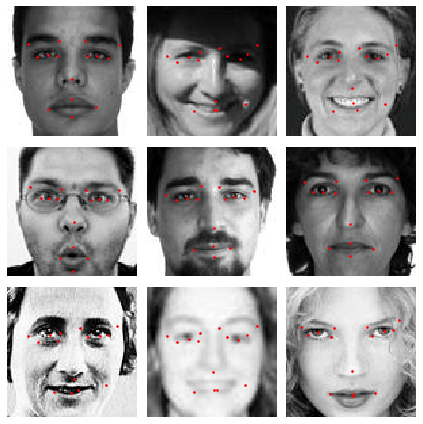

In [45]:
data.show_batch(3,figsize=(6,6))

In [0]:
# How Tensor.view() works? : https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch
# TLDR: Tensor.view is similar to numpy.reshape but it does not copy the tensor into memory (saves memory)

def MSELoss(actual,pred):
    actual = actual.view(-1,15,2)

    tmp = (actual - pred)
    loss = (tmp**2).sum(dim=2).sum(dim=1).sum()
    return loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


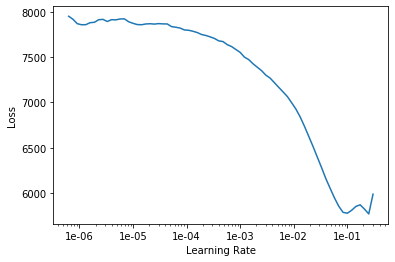

In [47]:
learn = cnn_learner(data,models.resnet101,loss_func=MSELoss)
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(10,max_lr=slice(3e-3,1e-1))

epoch,train_loss,valid_loss,time
0,897.159790,177.373245,12:05
1,154.176529,10.898947,00:38
2,27.023493,7.301726,00:39
3,9.280669,6.824963,00:38
4,6.587440,6.320252,00:39
5,6.197590,7.378200,00:38
6,5.777067,5.990875,00:38
7,5.321459,6.157947,00:38
8,4.643307,5.473890,00:38
9,4.087871,5.040724,00:38


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


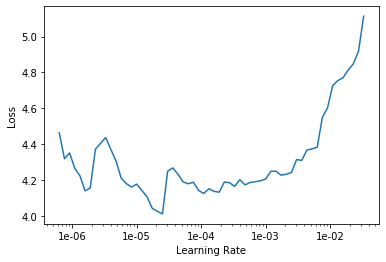

In [49]:
learn.save(os.path.join(ROOT_DIR,"frozen-resnet101-10epoch-IDKvalMSE"))
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20,max_lr=9e-7)

epoch,train_loss,valid_loss,time
0,3.979948,5.004973,00:34
1,4.035170,7.642426,00:34
2,3.935815,5.421720,00:34
3,3.883795,4.882553,00:34
4,3.875044,6.226526,00:34
5,3.624193,5.033089,00:34
6,3.621421,5.977318,00:35
7,3.508951,5.707201,00:34
8,3.553867,5.366906,00:35
9,3.538146,5.643112,00:34


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


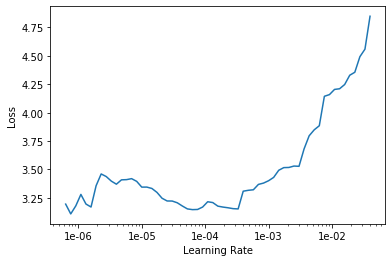

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10,max_lr=1e-4)

epoch,train_loss,valid_loss,time
0,3.335928,4.598642,00:34
1,3.520589,3.936564,00:34
2,3.120204,3.435664,00:34
3,2.739600,3.029156,00:34
4,2.233401,2.852885,00:34
5,2.045594,2.650699,00:34
6,1.736048,2.597580,00:34
7,1.595823,2.478950,00:34
8,1.615900,2.520370,00:34
9,1.448542,2.438833,00:34


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


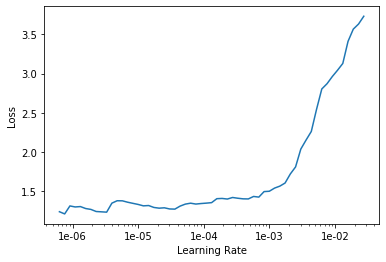

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3,max_lr =5e-6)

epoch,train_loss,valid_loss,time
0,1.421929,2.447115,00:34
1,1.460781,2.530812,00:34
2,1.373475,2.480316,00:34


In [0]:
learn.fit_one_cycle(3,max_lr=1e-5)


epoch,train_loss,valid_loss,time
0,1.480098,2.501997,00:34
1,1.429499,2.463293,00:34
2,1.426233,2.454099,00:34


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


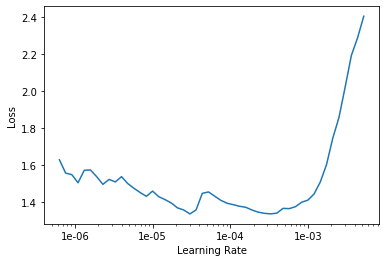

In [0]:
learn.save(os.path.join(ROOT_DIR,"resnet101-36epoch-2.45valMSE"))
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,max_lr=3e-3)

epoch,train_loss,valid_loss,time
0,3.371477,7.694940,00:28
1,3.987474,6.443917,00:27
2,3.466420,5.299884,00:27
3,2.722844,2.905257,00:27
4,2.042373,2.629123,00:27


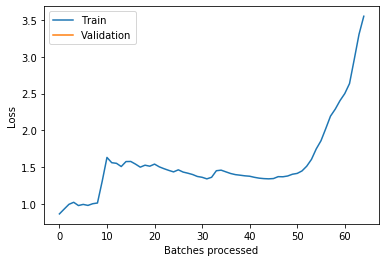

In [0]:
learn.recorder.plot_losses()

In [13]:
learn.load(os.path.join(ROOT_DIR,"resnet101-36epoch-2.45valMSE"))


Learner(data=ImageDataBunch;

Train: LabelList (6345 items)
x: PointsItemList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: PointsLabelList
ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96)
Path: /content/drive/My Drive/Colab Notebooks/data/facial-keypoints-detection/imgs/train;

Valid: LabelList (704 items)
x: PointsItemList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: PointsLabelList
ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96)
Path: /content/drive/My Drive/Colab Notebooks/data/facial-keypoints-detection/imgs/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxP

In [16]:
doc(learn.predict)

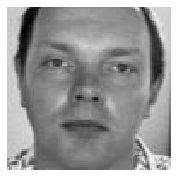

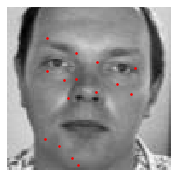

In [40]:
fn = os.path.join(TEST_DIR,"15.jpg")
img=open_image(fn=fn)
img.show()

tar = learn.predict(img)
img.show(y=tar[0])